In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_excel("products_dataset.xlsx")
df.head(2)

,Unnamed: 0,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,pid,product_details,seller,selling_price,sub_category,title,url
0,0,fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a,"2,999",3.9,York,Clothing and Accessories,"02/10/2021, 20:11:51",69% off,Yorker trackpants made from 100% rich combed c...,['https://rukminim1.flixcart.com/image/128/128...,False,TKPFCZ9EA7H5FYZH,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,921,Bottomwear,Solid Men Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...
1,1,893e6980-f2a0-531f-b056-34dd63fe912c,"1,499",3.9,York,Clothing and Accessories,"02/10/2021, 20:11:52",66% off,Yorker trackpants made from 100% rich combed c...,['https://rukminim1.flixcart.com/image/128/128...,False,TKPFCZ9EJZV2UVRZ,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,499,Bottomwear,Solid Men Blue Track Pants,https://www.flipkart.com/yorker-solid-men-blue...


# Data Cleaning

In [5]:
df = df.drop(columns=['Unnamed: 0', '_id', 'crawled_at', 'images', 'pid', 'product_details', 'url'], axis=1)

In [6]:
df.rename(columns={'description':'discount', 'discount':'description'}, inplace=True)

In [7]:
df=df.drop(columns=['description','title', 'sub_category'], axis=1)

In [8]:
df['discount'] = df['discount'].str.replace('% off', '')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual_price    29137 non-null  object 
 1   average_rating  27554 non-null  float64
 2   brand           27932 non-null  object 
 3   category        30000 non-null  object 
 4   discount        29059 non-null  object 
 5   out_of_stock    30000 non-null  bool   
 6   seller          28259 non-null  object 
 7   selling_price   29998 non-null  object 
dtypes: bool(1), float64(1), object(6)
memory usage: 1.6+ MB


# Handling Missing Values

In [10]:
df.isnull().sum()

actual_price       863
average_rating    2446
brand             2068
category             0
discount           941
out_of_stock         0
seller            1741
selling_price        2
dtype: int64

In [11]:
# Typecast for histogram plotting

df['actual_price'] = df['actual_price'].str.replace(',', '').astype(float)
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')
df['discount'] = pd.to_numeric(df['discount'], errors='coerce')

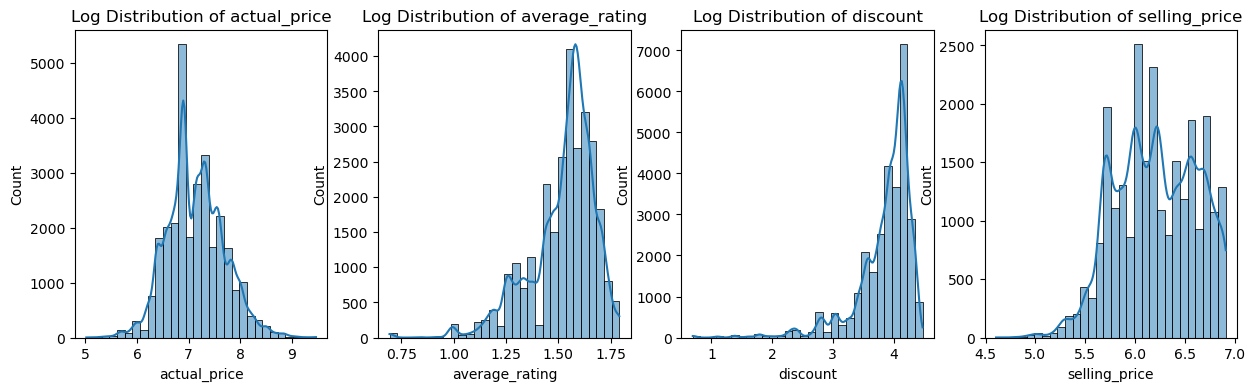

In [15]:
num_cols = ['actual_price', 'average_rating', 'discount', 'selling_price']

plt.figure(figsize=(15,4))
for i, col in enumerate(num_cols):
    plt.subplot(1,4,i+1)
    sns.histplot(np.log1p(df[col].dropna()), bins=30, kde=True)
    plt.title(f'Log Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.show()

In [16]:
# Filling numeric and categorical missing values
df.fillna(
    {
        'actual_price': df['actual_price'].mean(), 
        'average_rating': df['average_rating'].median(), 
        'discount': df['discount'].median(), 
        'selling_price': df['selling_price'].median(),
        'brand': 'Unknown',
        'seller': 'Unknown'
    }, inplace=True)

In [17]:
df.isnull().sum()

actual_price      0
average_rating    0
brand             0
category          0
discount          0
out_of_stock      0
seller            0
selling_price     0
dtype: int64

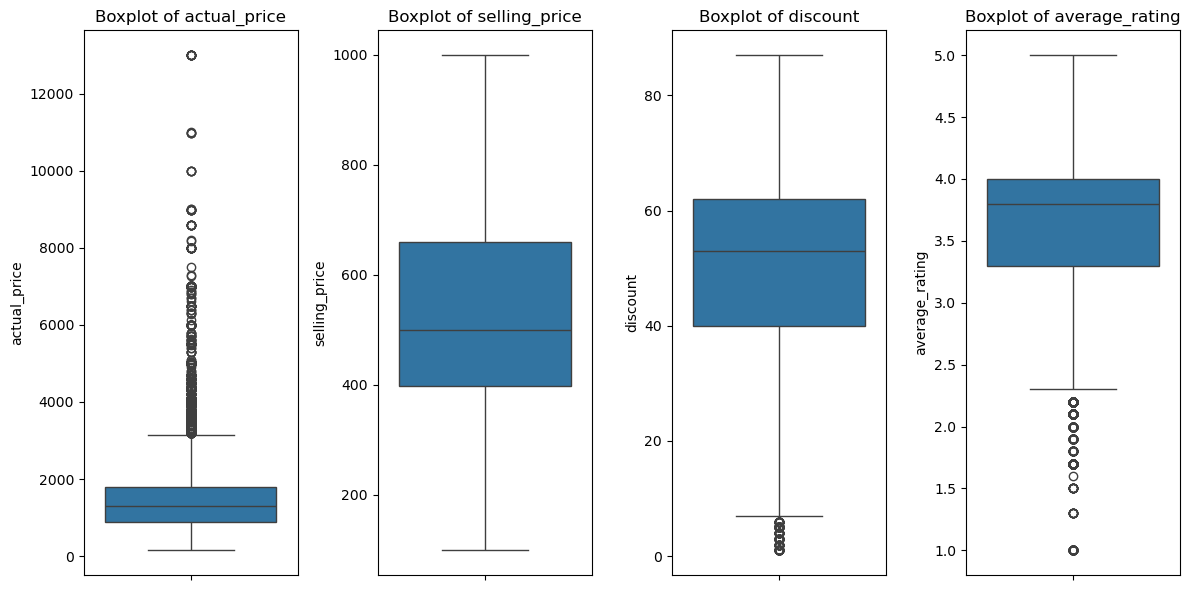

In [18]:
# Checking outliers using boxplot

num_cols = ['actual_price', 'selling_price', 'discount', 'average_rating']

plt.figure(figsize=(12,6))  
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()


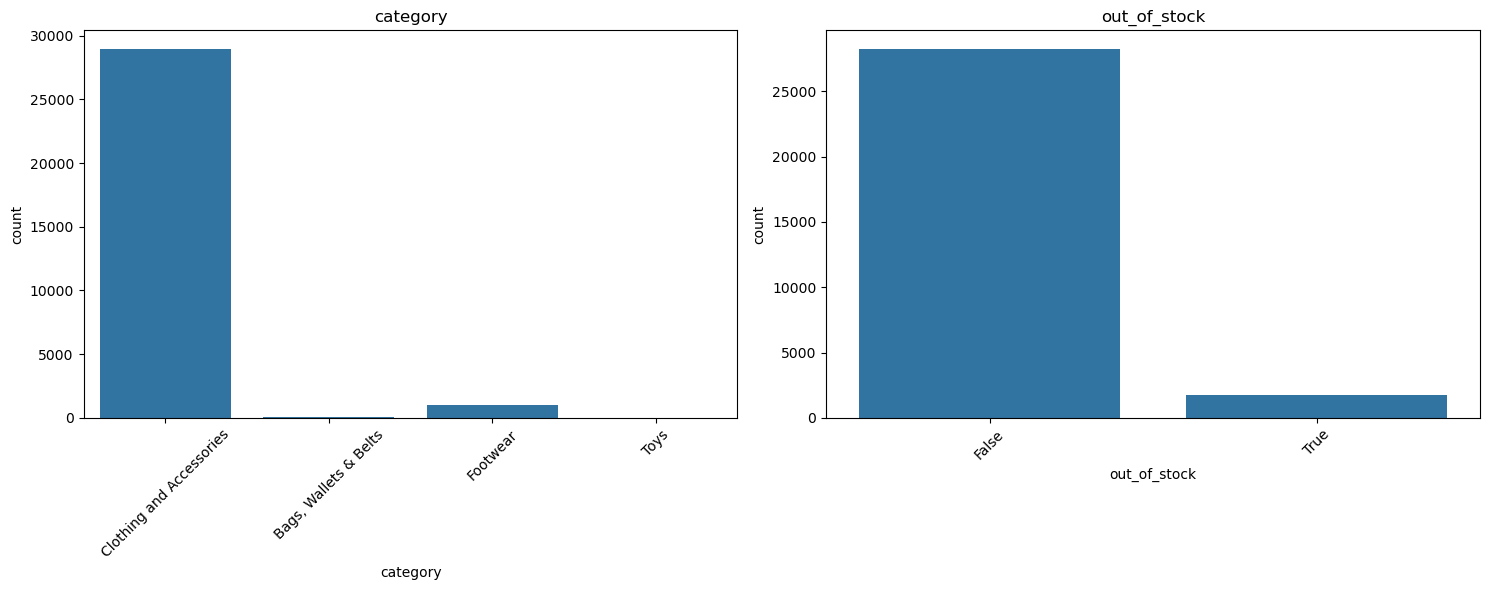

In [19]:
# Count plot
categorical_cols = ['category', 'out_of_stock']

plt.figure(figsize=(15,6))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.title(col)
plt.tight_layout()
plt.show()

In [20]:
df['category'] = df['category'].replace(['Footwear', 'Bags, Wallets & Belts', 'Toys'], 'Other')

df['out_of_stock'] = df['out_of_stock'].map({False:0, True:1})

In [21]:
print(df['category'].value_counts())
print("\n\n", df['out_of_stock'].value_counts())

category
Clothing and Accessories    28971
Other                        1029
Name: count, dtype: int64


 out_of_stock
0    28258
1     1742
Name: count, dtype: int64


# Data Visualization

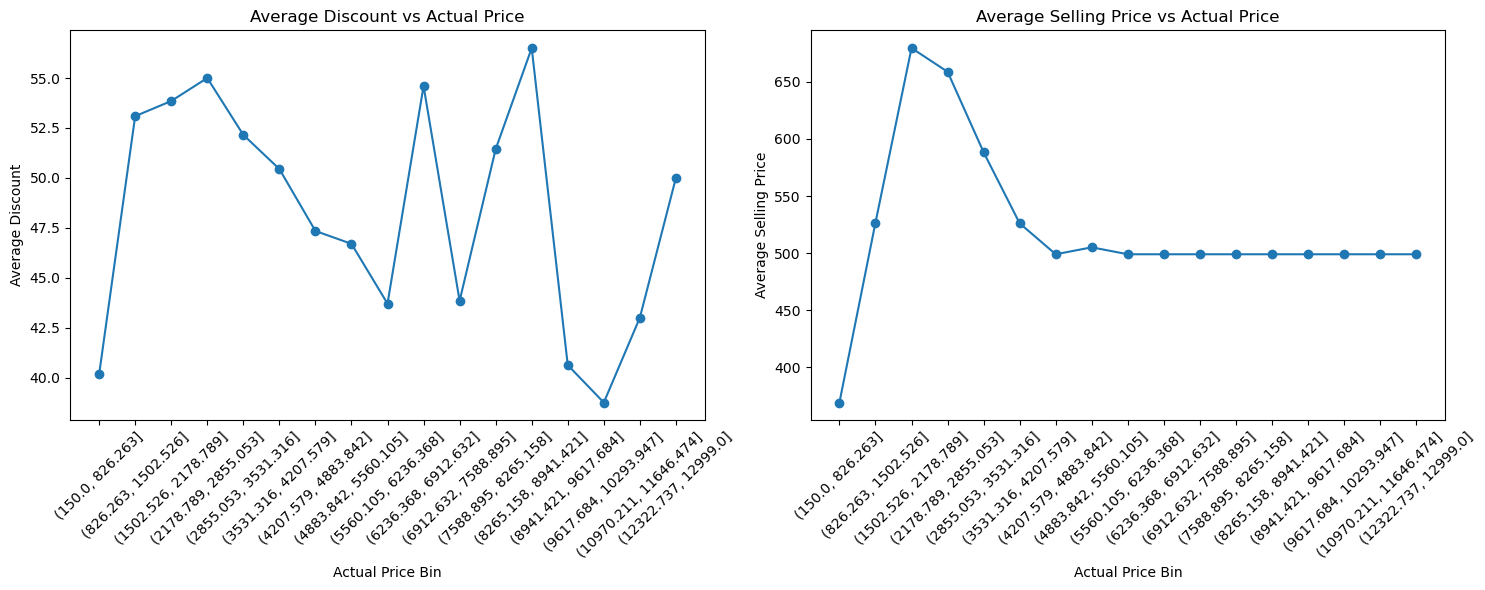

In [22]:
# create temporary bins
bins = np.linspace(df['actual_price'].min(), df['actual_price'].max(), 20)

# use bins directly in groupby
bin_avg_discount = (
    df.groupby(pd.cut(df['actual_price'], bins), observed=True)['discount']
      .mean()
      .reset_index()
)

bin_avg_selling = (
    df.groupby(pd.cut(df['actual_price'], bins), observed=True)['selling_price']
      .mean()
      .reset_index()
)

# plots
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(bin_avg_discount.iloc[:, 0].astype(str), bin_avg_discount['discount'], marker='o')
plt.xticks(rotation=45)
plt.title('Average Discount vs Actual Price')
plt.xlabel('Actual Price Bin')
plt.ylabel('Average Discount')

plt.subplot(1, 2, 2)
plt.plot(bin_avg_selling.iloc[:, 0].astype(str), bin_avg_selling['selling_price'], marker='o')
plt.xticks(rotation=45)
plt.title('Average Selling Price vs Actual Price')
plt.xlabel('Actual Price Bin')
plt.ylabel('Average Selling Price')

plt.tight_layout()
plt.show()

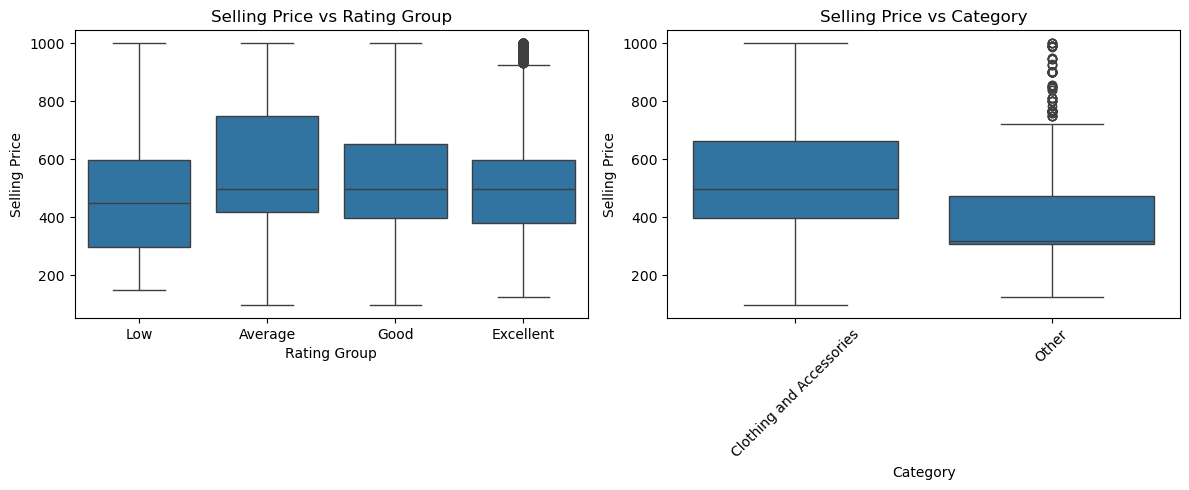

In [23]:
# Box Plot
plt.figure(figsize=(12,5))

# Boxplot 1: Selling price vs rating
plt.subplot(1, 2, 1)
# create rating bins 
rating_bins = pd.cut(
    df['average_rating'],
    bins=[0, 2, 3, 4, 5],
    labels=['Low', 'Average', 'Good', 'Excellent']
)

sns.boxplot(x=rating_bins, y=df['selling_price'])
plt.title('Selling Price vs Rating Group')
plt.xlabel('Rating Group')
plt.ylabel('Selling Price')

# Boxplot 2: Selling price vs category
plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='selling_price', data=df)
plt.title('Selling Price vs Category')
plt.xlabel('Category')
plt.ylabel('Selling Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Categorical Encoding

In [24]:
# Binary encoding for category
df['category'] = df['category'].apply(lambda x: 1 if x == 'Clothing and Accessories' else 0)

# Top N brands (e.g., top 10), rest as 'Other'
top_brands = df['brand'].value_counts().nlargest(10).index
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'Other')
brand_dummies = pd.get_dummies(df['brand'], prefix='brand', drop_first=True)

# Top N sellers (e.g., top 10), rest as 'Other'
top_sellers = df['seller'].value_counts().nlargest(10).index
df['seller'] = df['seller'].apply(lambda x: x if x in top_sellers else 'Other')
seller_dummies = pd.get_dummies(df['seller'], prefix='seller', drop_first=True)

# Combine dummies with original df
df_encoded = pd.concat([df.drop(['brand','seller'], axis=1), brand_dummies, seller_dummies], axis=1)


# Data Splitting

In [25]:
X = df_encoded.drop('selling_price', axis=1) 
y = df_encoded["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
# Check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (21000, 25)
X_test: (9000, 25)
y_train: (21000,)
y_test: (9000,)


# Standardization (Preprocessing)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled array to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head(3)

,actual_price,average_rating,category,discount,out_of_stock,brand_Amp,brand_Black Beat,brand_ECKO Unl,brand_Free Authori,brand_Keo,...,seller_AMALGUS ENTERPRISE,seller_ARBOR,seller_ArvindTrueBlue,seller_BioworldMerchandising,seller_Black Beatle,seller_Keoti,seller_Other,seller_RetailNet,seller_SandSMarketing,seller_Unknown
0,-0.499362,-0.090781,0.188693,0.815076,-0.246183,-0.146629,-0.139524,-0.182794,-0.168832,-0.150811,...,-0.132254,-0.18487,-0.134106,-0.167334,-0.139524,-0.150811,0.655470,-0.243122,-0.176151,-0.246074
1,2.132414,0.538341,0.188693,-0.151192,-0.246183,-0.146629,-0.139524,-0.182794,-0.168832,-0.150811,...,-0.132254,-0.18487,-0.134106,-0.167334,-0.139524,-0.150811,-1.525622,4.113160,-0.176151,-0.246074
2,-0.499362,-0.719902,0.188693,0.573509,-0.246183,-0.146629,-0.139524,-0.182794,-0.168832,-0.150811,...,-0.132254,-0.18487,-0.134106,-0.167334,-0.139524,-0.150811,0.655470,-0.243122,-0.176151,-0.246074


# Model 1 - Linear Regression

In [28]:
# Initialize LR regressor
lr = LinearRegression()

# Fit on training data
lr.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = lr.predict(X_test_scaled)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test,y_pred)

print(f"LR Mean Squared Error: {mse_lr:.2f}")
print(f"LR Root Mean Squared Error: {rmse_lr:.2f}")
print(f"LR R-squared: {r2_lr:.2f}")

LR Mean Squared Error: 30908.62
LR Root Mean Squared Error: 175.81
LR R-squared: 0.20


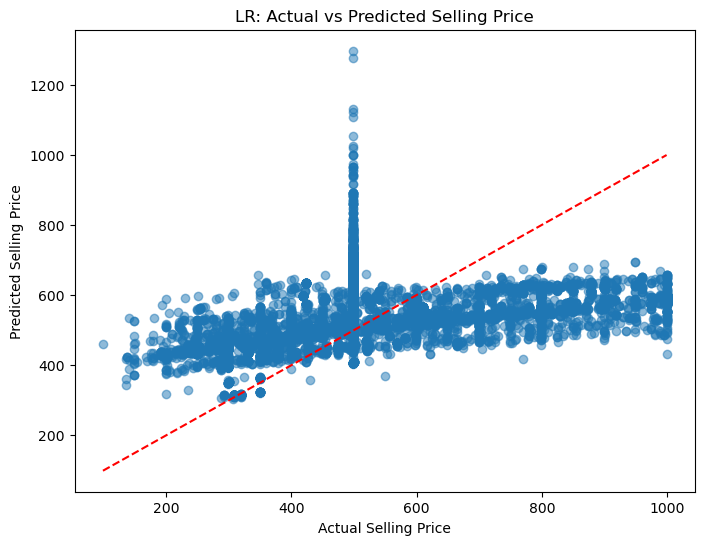

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("LR: Actual vs Predicted Selling Price")
plt.show()

# Model 2 - Support Vector Regression

In [30]:
# Initialize SVM regressor (RBF kernel)
svm_model = SVR(kernel='rbf')

# Fit on training data
svm_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_untuned = svm_model.predict(X_test_scaled)

# Evaluate
mse_svm = mean_squared_error(y_test, y_pred_untuned)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, y_pred_untuned)

print(f"SVM Mean Squared Error: {mse_svm:.2f}")
print(f"SVM Root Mean Squared Error: {rmse_svm:.2f}")
print(f"SVM R-squared: {r2_svm:.2f}")


SVM Mean Squared Error: 26951.56
SVM Root Mean Squared Error: 164.17
SVM R-squared: 0.30


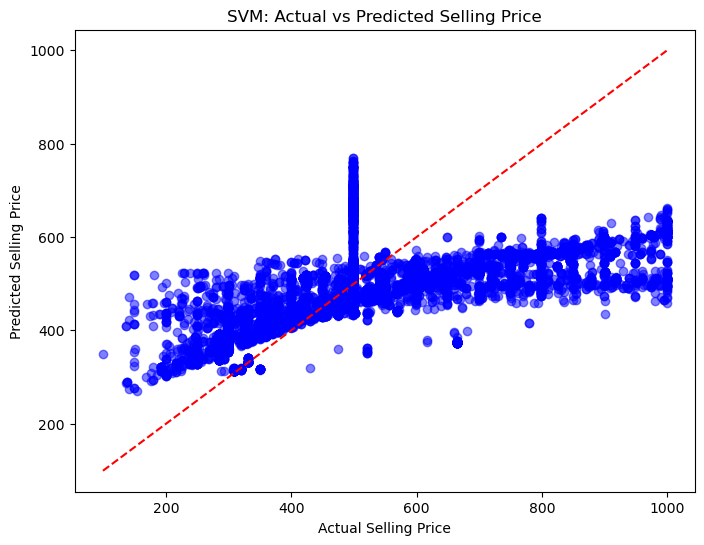

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_untuned, alpha=0.5, color='blue', label='Untuned SVM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("SVM: Actual vs Predicted Selling Price")
plt.show()


# Hyperparameter tuning for SVM

In [32]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

# Initialize SVM regressor
svr = SVR(kernel='rbf')

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Predict on test data using best estimator
best_svm = grid_search.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test_scaled)

# Evaluate
mse_svm = mean_squared_error(y_test, y_pred_svm_tuned)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, y_pred_svm_tuned)

print(f"Tuned SVM Mean Squared Error: {mse_svm:.2f}")
print(f"SVM Root Mean Squared Error: {rmse_svm:.2f}")
print(f"Tuned SVM R-squared: {r2_svm:.2f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 100, 'epsilon': 1, 'gamma': 1}
Tuned SVM Mean Squared Error: 5251.03
SVM Root Mean Squared Error: 72.46
Tuned SVM R-squared: 0.86


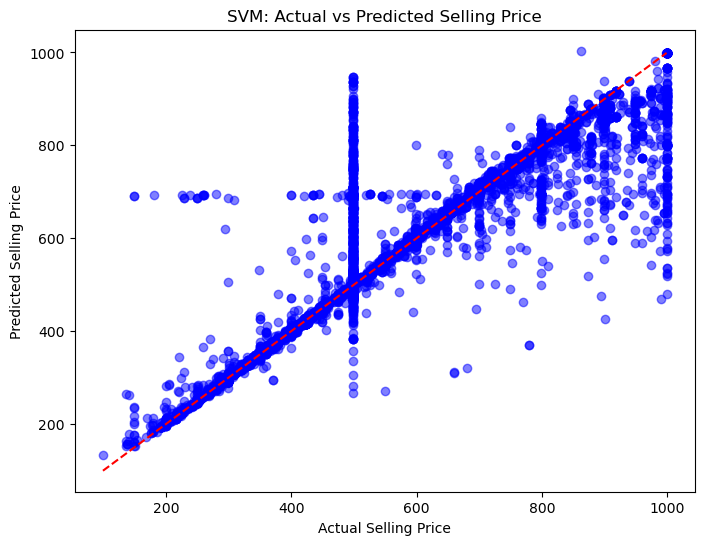

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_svm_tuned, alpha=0.5, color='blue', label='Tuned SVM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("SVM: Actual vs Predicted Selling Price")
plt.show()

# Model 3 - K-Nearest Neighbors

In [35]:
# Initialize KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  

# Fit on training data
knn_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Mean Squared Error: {mse_knn:.2f}")
print(f"KNN Root Mean Squared Error: {rmse_knn:.2f}")
print(f"KNN R-squared: {r2_knn:.2f}")


KNN Mean Squared Error: 3467.40
KNN Root Mean Squared Error: 58.88
KNN R-squared: 0.91


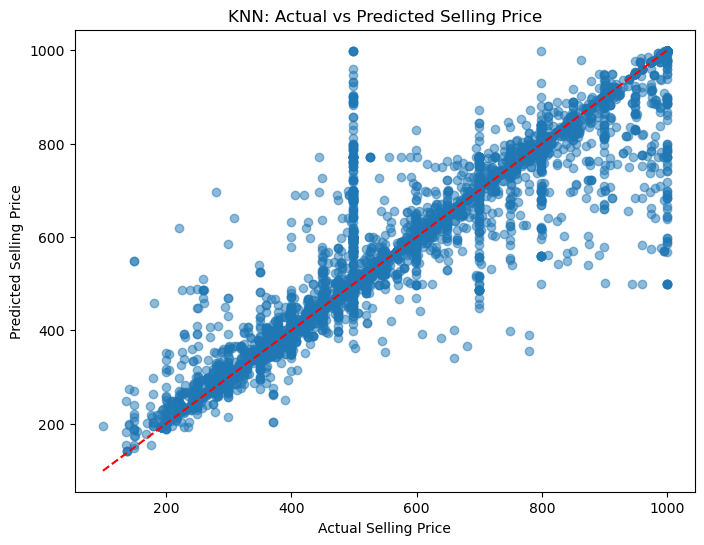

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("KNN: Actual vs Predicted Selling Price")
plt.show()
